In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from scipy.linalg import lstsq
import heapdict

Locally Linear Embedding, or LLE, is a non-linear dimensionality reduction technique that computes low dimensional, neighborhood preserving embeddings of data. It is attempts to discover non-linear relationships at data. It is made up of 3 steps:
1. Compute the closest neighbors of data
2. Compute the representation weights of the data using it's k closest neighbors
3. Compute the embedding of the representation in a lower dimension.

I decided to compute the LLE of the 1's in the MNIST dataset. We find the closest 20 neighbors by euclidian distance and a priority queue.

In [4]:
def get_dist(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))
    
def get_k_nearest(dataset,k):
    output = []
    
    for i in range(len(dataset)):
        h = heapdict.heapdict()
        for j in range(len(dataset)):
            if(i!=j):
                h[j] = get_dist(dataset[i], dataset[j])
        closest = []
        for _ in range(k):
            closest.append(h.popitem()[0])
        output.append(closest)
    return output
            
def filter_1(x, y):
    keep = (y == 1)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

            
    

In [5]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

x_ones, y_ones = filter_1(X_train[:6000], Y_train[:6000])
k = 20
dataset = x_ones
print(np.shape(dataset))

nearest_neighbors = get_k_nearest(dataset, k)

(671, 28, 28)


We then calculate the weights of each datapoint based on its neighbors. We do this by minimizing the mean squared error of the representation of X with the actual value of X. Each row of the weight matrix W must sum to 1. The problem boils down to minimizing a constrained least squares problem, which we already know how to do.

In [6]:
def get_weight_matrix(nearest_neighbors, dataset,i):
    A =[]
    ind = nearest_neighbors[i]
    flattened = dataset[i].flatten()
    nearest_set = set(nearest_neighbors[i])
    for j in nearest_set:
        A.append(dataset[j].flatten() - flattened)
        
    C = np.matmul(A, np.array(A).T)
    W_i =np.linalg.solve(C, np.ones(len(C)).T)
    full_weights = np.zeros(len(dataset))
    W_i = W_i/np.sum(W_i)
    full_weights[ind] = W_i

    
    return full_weights
    
    
    
    
 
 
 
        
        


In [7]:
indexes = np.arange(0, len(dataset))

W = []

for i in indexes:
    W.append(get_weight_matrix(nearest_neighbors, dataset, i))
print(np.shape(W))

(671, 671)


Now that we have the weight matrix W, we have to calculate the embedding in a lower dimension. I chose to calculate the embedding in 2 dimensions for ease of visualization. The embedding cost function is also means squared error, although in this case it is minimizing the difference between Y(the lower dimensional represenation of X) with the other lower dimensional representations. In order to minimize this function, we can solve a sparse eigenvalue problem.  The bottom 1 to d+1 vectors of an NxN sparse matrix correspond to an orthogonal set of coordinates. We sparsify W by subtracting it from I and multiplying the resulting matrix by its conjugate transpose. 

In [8]:
M = np.matmul(np.identity(len(W)) - W, np.conj(np.identity(len(W))- W).T)

In [9]:
d = 2
Y = np.linalg.eig(M)[1][1:d+1].T
print(np.shape(Y))


(671, 2)


Let's visualize the embeddings we got!

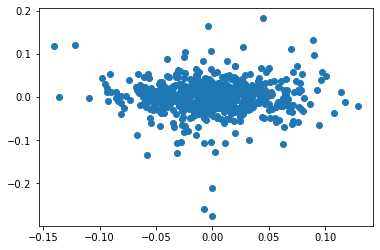

In [10]:
plt.scatter(Y[:,0],Y[:,1])

As you can see, neighborhood relationships tend to be preserved by LLE!